In [504]:
import os
import glob

# Definir diretório base
dir = "observations/"
observation_date = "2011-06-26"
base_path = os.path.join(dir, f'{observation_date}/')

# Usar glob para encontrar todos os arquivos .fit no diretório
file_pattern = os.path.join(base_path, '*.fit')
fits_files = glob.glob(file_pattern)
image_names = sorted([f for f in fits_files if not ('pg1530-021.fit' <= os.path.basename(f) <= 'pg1530-050.fit')])
print(image_names)
print(len(image_names))

['observations/2011-06-26/pg1530-001.fit', 'observations/2011-06-26/pg1530-002.fit', 'observations/2011-06-26/pg1530-003.fit', 'observations/2011-06-26/pg1530-004.fit', 'observations/2011-06-26/pg1530-005.fit', 'observations/2011-06-26/pg1530-006.fit', 'observations/2011-06-26/pg1530-007.fit', 'observations/2011-06-26/pg1530-008.fit', 'observations/2011-06-26/pg1530-009.fit', 'observations/2011-06-26/pg1530-010.fit', 'observations/2011-06-26/pg1530-011.fit', 'observations/2011-06-26/pg1530-012.fit', 'observations/2011-06-26/pg1530-013.fit', 'observations/2011-06-26/pg1530-014.fit', 'observations/2011-06-26/pg1530-015.fit', 'observations/2011-06-26/pg1530-016.fit', 'observations/2011-06-26/pg1530-017.fit', 'observations/2011-06-26/pg1530-018.fit', 'observations/2011-06-26/pg1530-019.fit', 'observations/2011-06-26/pg1530-020.fit']
20


In [505]:
from astropy.io import fits

images_data = []

# Carregar a imagem FITS
for fits_file in image_names:
    hdu = fits.open(fits_file)

    images_data.append(hdu[0].data)

print(type(images_data))
print(type(images_data[0]))
len(images_data)

<class 'list'>
<class 'numpy.ndarray'>


20

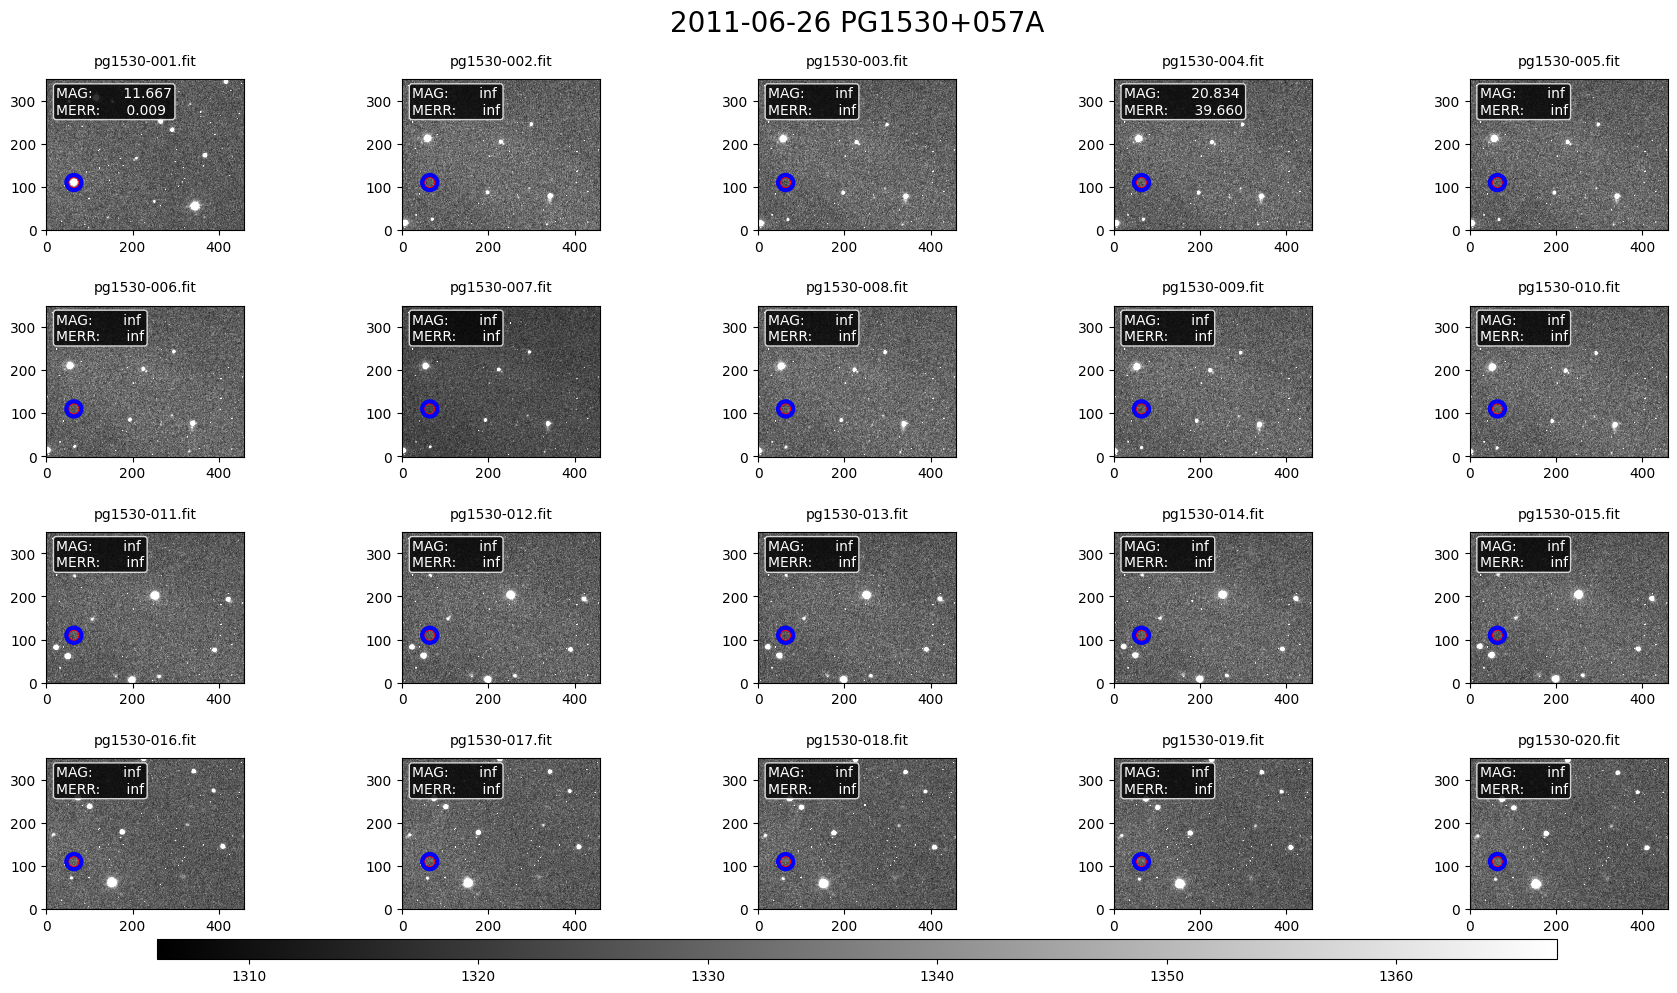

In [525]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry, ApertureStats

# Raio da abertura
radius_aperture = 13

# Limitar a quantidade de imagens para plotar (no máximo 50 para 4x5)
num_images_to_plot = len(image_names)
rows = 4
columns = 5

# Aumentar a altura da figura
fig, axes = plt.subplots(rows, columns, figsize=(20, 10))  # Aumente a altura aqui

fig.suptitle(f"{observation_date} PG1530+057A", fontsize=20, y=1)  # Ajuste o y conforme necessário para não cortar o título

# Array para armazenar as imagens para a colorbar
ims = []  # Para armazenar os objetos de imagem
for i in range(num_images_to_plot):
    image_data = images_data[i]
    
    image_section = image_data[350:700, 450:910]
    x_cropped_star = 64  # Coordenadas x da estrela
    y_cropped_star = 110  # Coordenadas y da estrela

    # Criar abertura
    aperture_cropped = CircularAperture((x_cropped_star, y_cropped_star), r=radius_aperture)

    # Definir os raios da abertura e do anel
    radius_in = 15         # Raio interno do anel (igual ao IRAF)
    dannulus  = 5          # Largura do anel de fundo

    # Annulus
    annulus = CircularAnnulus((x_cropped_star, y_cropped_star), r_in=radius_in, r_out=radius_in + dannulus)

    # Fotometria de abertura
    photometry = aperture_photometry(image_section, aperture_cropped)

    # Contribuição do Céu
    bkg       = ApertureStats(image_section, annulus)
    bkg_sum   = bkg.sum
    bkg_mean  = bkg.mean
    total_bkg = bkg_mean  * aperture_cropped.area

    star_flux = photometry["aperture_sum"] - total_bkg
    FERR = np.sqrt(photometry['aperture_sum'][0]) + np.sqrt(bkg_sum)

    zmag     = 25  # IRAF
    mag      = zmag -2.5*np.log10(star_flux) if star_flux > 0 else np.inf

    if star_flux > 0:
        MERR = (1.0857 * FERR) / star_flux[0]
    else:
        MERR = np.inf  # Erro infinito se o fluxo total for zero

     # Adicionar informações como labels na imagem
    textstr = '\n'.join((
        # f"TOTAL SUM: {photometry['aperture_sum'][0]:.3f}",
        # f"BKG SUM:   {bkg_sum:.3f}",
        # f"STAR FLUX: {star_flux.value[0]:.3f}",
        # f"FERR:      {FERR:.3f}",
        f"MAG:       {mag[0]:.3f}" if isinstance(mag, np.ndarray) else f"MAG:       {mag:.3f}",
        f"MERR:      {MERR:.3f}",
        # f"APERTURE:  {radius_aperture}",
        # f"ANNULUS:   {radius_in + dannulus}",
    ))
    
    #print(textstr)

    # Definindo limites de exibição
    vmin = np.percentile(image_data, 1)
    vmax = np.percentile(image_data, 99)  # Alterado para 99 para melhor visualização

    ax = axes[i // columns, i % columns]  # Obtém a posição correta no layout 4x5

    # Plotar a imagem
    im = ax.imshow(image_section, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
    ims.append(im)  # Armazenar a imagem para a colorbar
    aperture_cropped.plot(color='red', lw=1.5, ax=ax, label='Aperture')
    annulus.plot(color='blue', lw=1.5, ax=ax, label='Annulus')
    
    # Criar legenda para cada subplot
    #ax.legend(loc='upper right', fontsize=8)  # Adicionando a legenda

    # Definir a posição do texto (ajuste conforme necessário)
    x_text = 0.05 * image_section.shape[1]  # 5% da largura da imagem
    y_text = 0.95 * image_section.shape[0]  # 95% da altura da imagem
    
    # Adicionar o texto à imagem
    ax.text(x_text, y_text,
            textstr,
            fontsize=10, color='white', ha='left', va='top',
            bbox=dict(boxstyle='round,pad=0.2', edgecolor='white', facecolor='black', alpha=0.8))

    # Adicionar título
    ax.set_title(image_names[i].split("/")[-1], fontsize=10, pad=10)  # Título reduzido com padding

    # Adicionar rótulos aos eixos
    #ax.set_xlabel("Pixels")
    #ax.set_ylabel("Pixels")

# Criar uma única colorbar para todos os subplots na parte inferior
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # Ajuste [left, bottom, width, height]
cbar = plt.colorbar(ims[0], cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=10)  # Ajustar tamanho das labels do colorbar

# Remover eixos de imagens não utilizadas, se houver
for j in range(num_images_to_plot, rows * columns):
    axes[j // columns, j % columns].axis('off')

# Ajustar layout para evitar sobreposições
plt.subplots_adjust(top=0.93, bottom=0.1, left=0.07, right=0.93, hspace=0.5, wspace=0.2)
plt.savefig(observation_date)
plt.show()
